In [1]:
# Import libraries 
import scanpy as sc
import pandas as pd 
import matplotlib.pyplot as plt
import anndata as ad 
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


In [2]:
# Laod count matrixes for samples and Transpose (Rows: Genes, Columns: Cells -> Rows: Cells, Columns: Genes)
wt1 = sc.read_csv("/data/BIOL5177/Assessment/WT1/counts_matrix.csv").T
inf1 = sc.read_csv("/data/BIOL5177/Assessment/Infected1/counts_matrix.csv").T
inf2 = sc.read_csv("/data/BIOL5177/Assessment/Infected2/counts_matrix.csv").T


# Add group columns
wt1.obs["Group"] = "Wildtype"
inf1.obs["Group"] = "Infected"
inf2.obs["Group"] = "Infected" 

# Add sample columns
wt1.obs["Sample"] = "Wildtype1"
inf1.obs["Sample"] = "Infected1"
inf2.obs["Sample"] = "Infected2" 

# Put samples togeter in a list
samples = [wt1, inf1, inf2]  

# Pre-processing 

In [3]:
# Loop through each sample to perform QC steps  
for sample in samples: 
    sample.var["mt"] = sample.var_names.str.startswith("mt-")                      # Add column for the number of mitocondrial genes
    sc.pp.calculate_qc_metrics(sample, qc_vars=["mt"], log1p=False, inplace=True)  # Calculate QC metrics
    sc.pp.filter_genes(sample, min_cells = 2)                                      # Filter genes that are expressed in less than 2 cells  
    sc.pp.filter_cells(sample, min_genes = 40)                                     # Filter cells that have less than 40 genes expressed


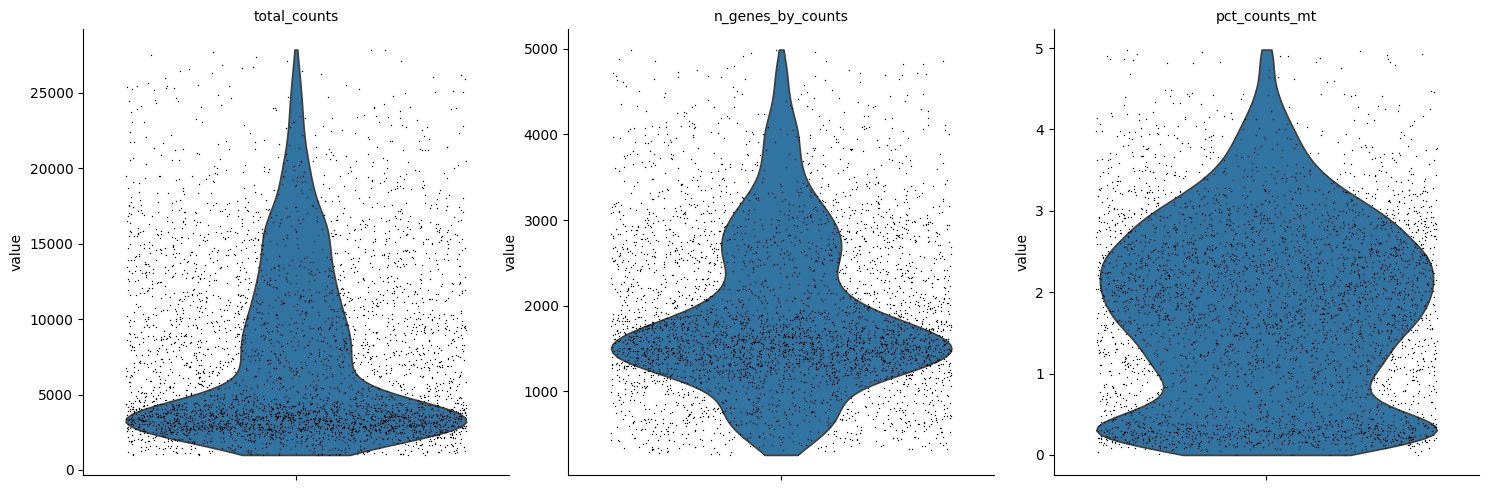

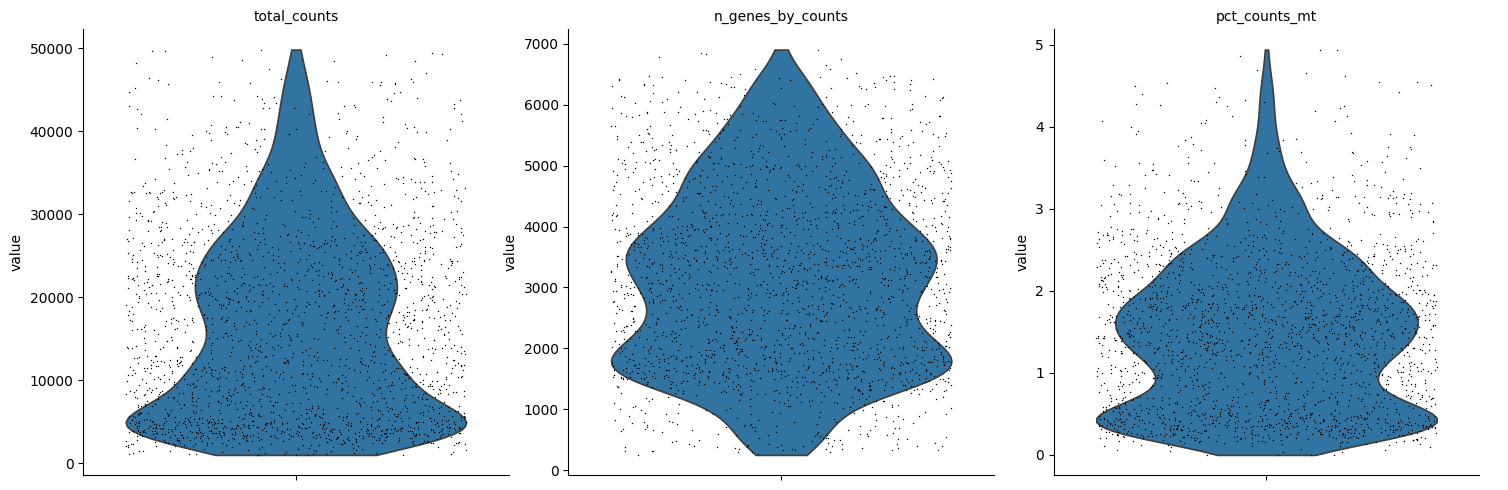

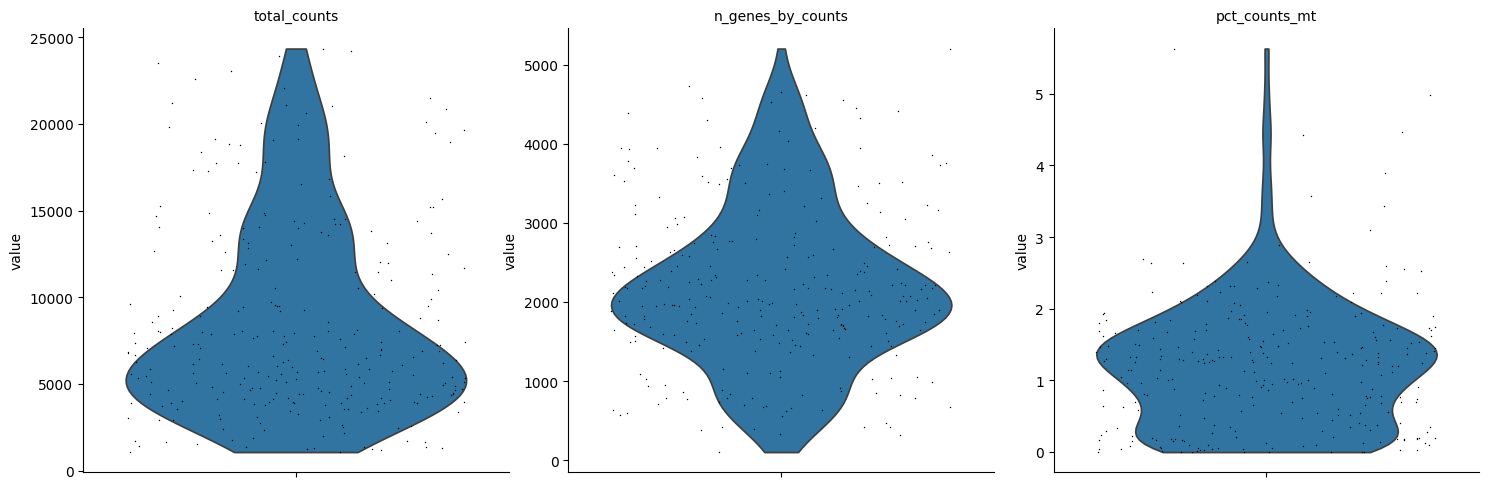

In [4]:
# Loop thorugh for generating violoin plot 

for sample in samples: 
    sc.pl.violin(
        sample,
        ["total_counts", "n_genes_by_counts" , "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

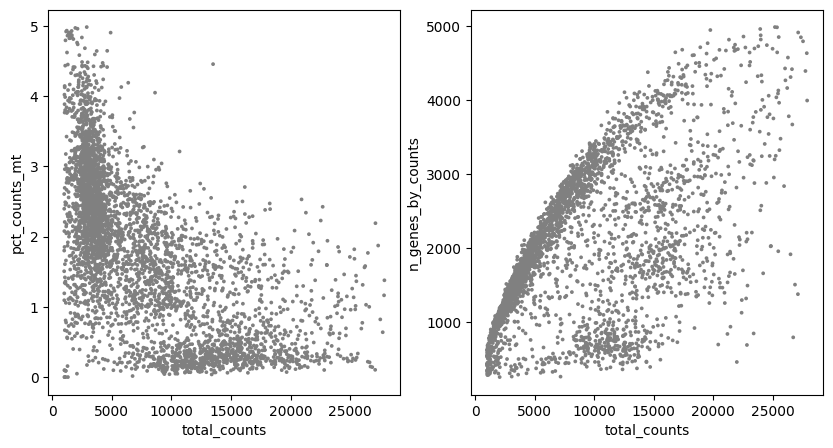

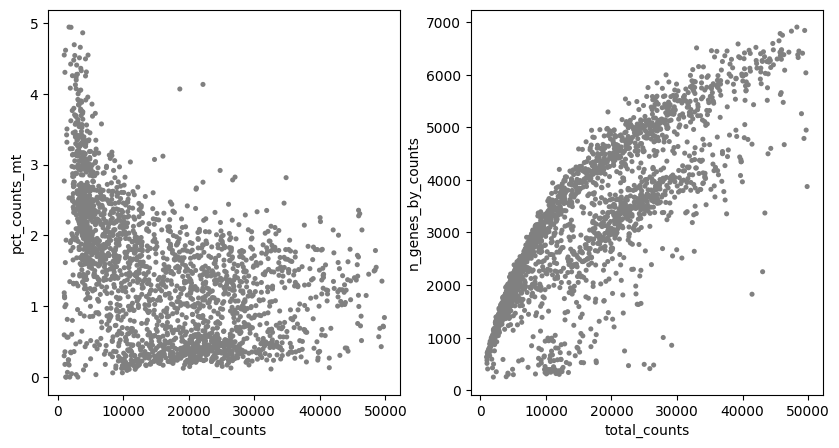

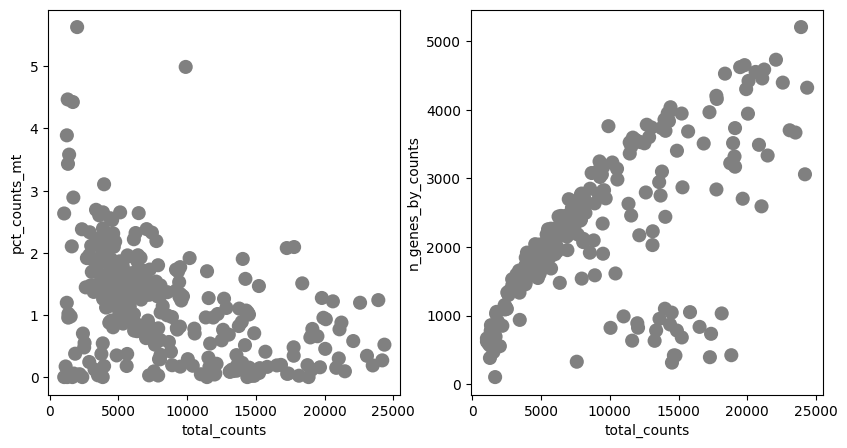

In [5]:
# Loop through for generating scatter plots 

for sample in samples: 
    fig, axes = plt.subplots(1, 2, figsize=(10,5))                                          # Create subplot
    sc.pl.scatter(sample, x="total_counts", y="pct_counts_mt",ax=axes[0], show=False)       # Total counts vs Mitochondrial genes 
    sc.pl.scatter(sample, x="total_counts", y="n_genes_by_counts", ax=axes[1], show=False)  # Total counts vs the Number of genes   
    

In [6]:
# Filter out based on parameters 

filtered = []

for sample in samples: 
    
    sample = sample[(sample.obs.n_genes_by_counts > 200) & (sample.obs.n_genes_by_counts < 4200), :]   # Filter cells that have less than 200 genes & have more than 4200 genes
    sample = sample[sample.obs.pct_counts_mt < 5, :].copy()                                            # Filter cells that have more than 5 mitocondrial genes  
   
    filtered.append(sample) 

# Normalizing data

In [7]:
# Merge all dataset in 'filtered' list 
combined = ad.concat(filtered)
combined.obs
combined_raw = combined.copy()  # Make copy the data befor normalization step                                                      

# delete the unnecesaary objects 
del wt1
del inf1
del inf2

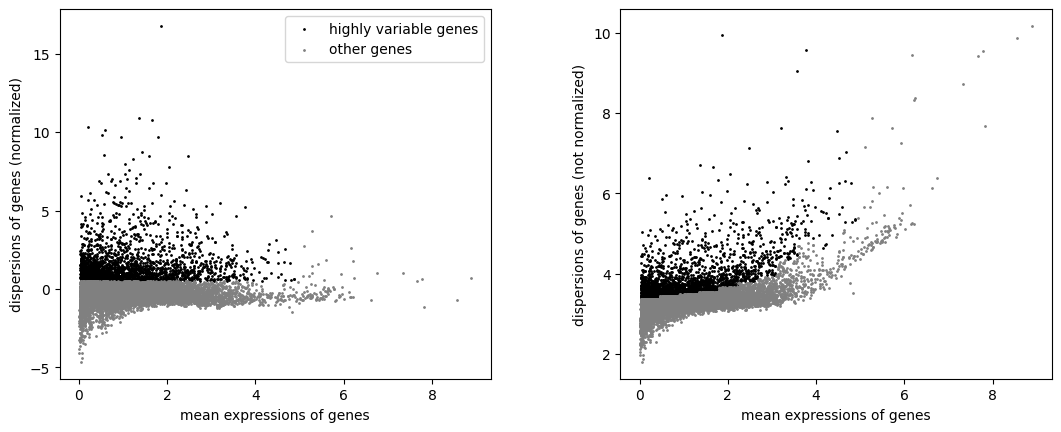

/home1/bioinfo-35/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
# Normalize combinded data 
                                                    
sc.pp.normalize_total(combined, target_sum=10e4)                                   # Nomalized the data 
sc.pp.log1p(combined)                                                              # Logarithmize the data
sc.pp.highly_variable_genes(combined, min_mean=0.0125, max_mean=5, min_disp=0.5)   # Identify highly-variable genes 
sc.pl.highly_variable_genes(combined)
combined.raw = combined.copy()                                                     # Store 
combined = combined[:,combined.var.highly_variable]                                # Filter with highly variable genes
sc.pp.scale(combined, max_value=10)                                                # Scale the data 


### Principal Component Analysis (PCA)

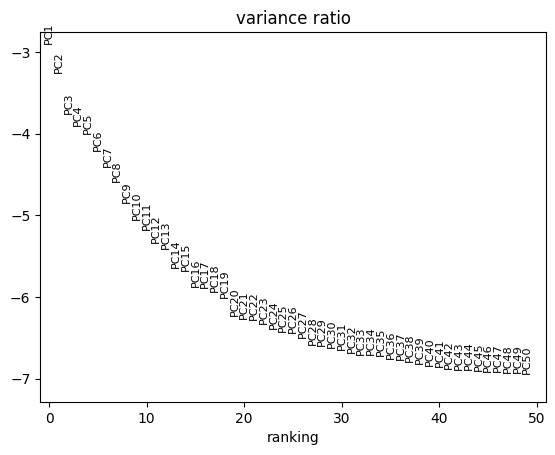

In [9]:
sc.tl.pca(combined, svd_solver="arpack")                 # Reduce the dimensionality of the data
sc.pl.pca_variance_ratio(combined, log=True, n_pcs = 50) # Create elbow plot 

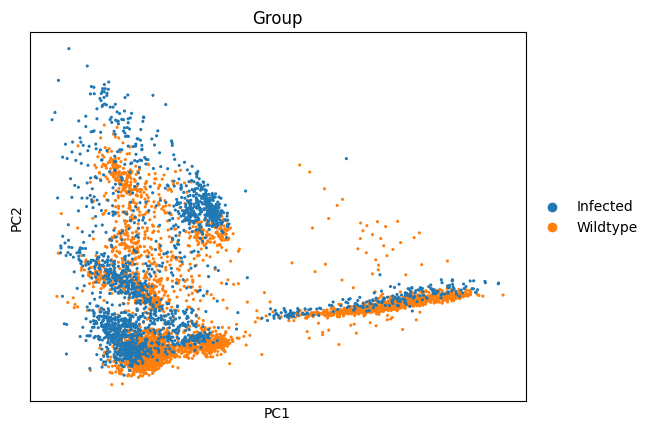

In [10]:
sc.pl.pca(combined, color="Group")

### Clustering the neighborhood graph

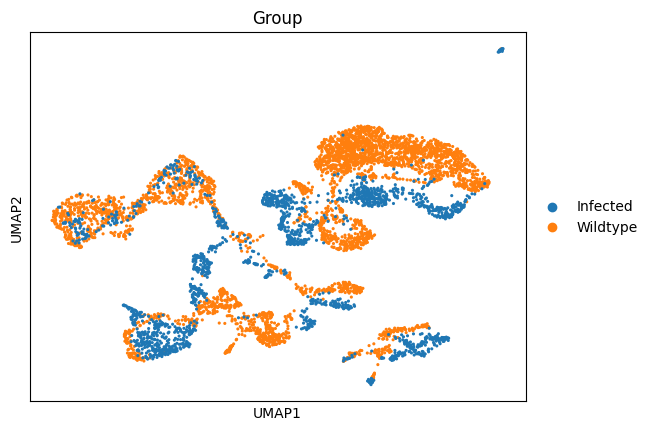

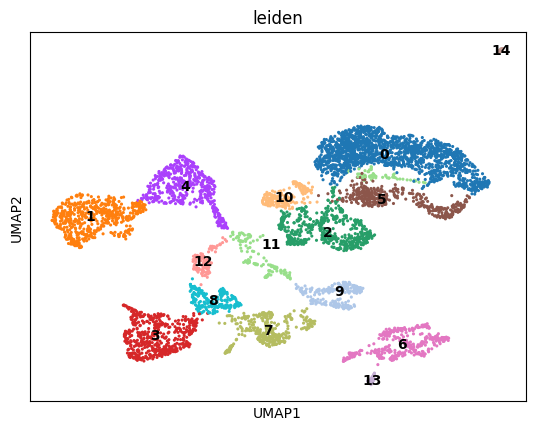

In [11]:
sc.pp.neighbors(combined, n_neighbors = 15, n_pcs = 32)          # Create the neighborhood graph 
sc.tl.leiden(combined, resolution = 0.2)                         # Cluster with Leiden graph method

sc.tl.umap(combined)                                             # Run UMAP
sc.pl.umap(combined, color = "Group")                            # Plot the clusters 
sc.pl.umap(combined, color = "leiden", legend_loc = "on data")   # To compare cluster's location 

 # Integration with BBKNN 

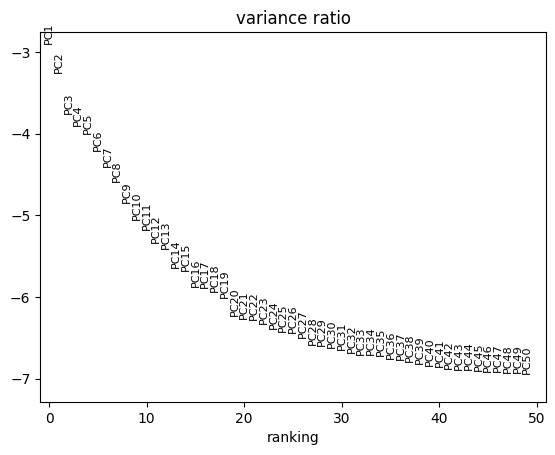

In [12]:
# code refererence: https://www.sc-best-practices.org/cellular_structure/integration.html 
combined_b = combined.copy()                           # To avoid to overlap the result from harmony integration
sc.pp.pca(combined_b)                                  # Run PCA 
sc.external.pp.bbknn(combined_b, batch_key = "Group")  # Run BBKNN
sc.pl.pca_variance_ratio(combined_b, log=True, n_pcs = 50)

## Perform analysis

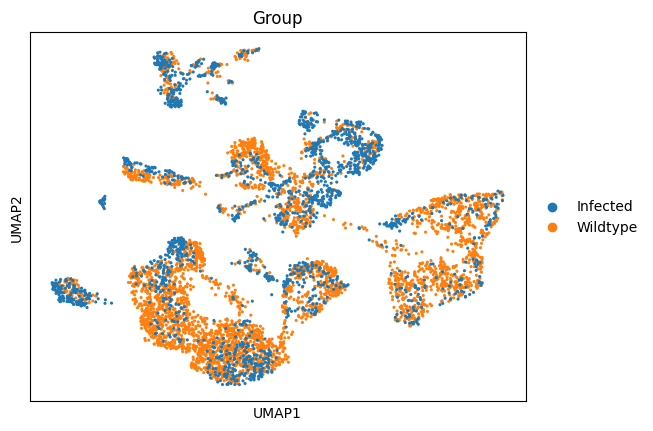

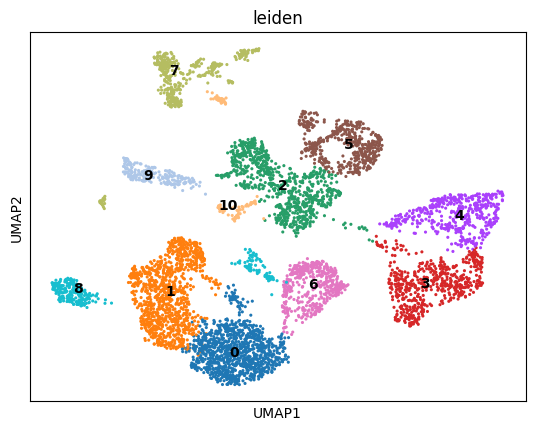

In [13]:
sc.tl.leiden(combined_b, resolution = 0.2)                          # Cluster with Leiden graph method
sc.tl.umap(combined_b)                                              # Run UMAP
sc.pl.umap(combined_b, color = "Group")                             # Plot the clusters based on "Group"
sc.pl.umap(combined_b, color = "leiden", legend_loc = "on data")    # Plot the clusters based on "Leiden"

## Annotation of Cell type with three largest clusters

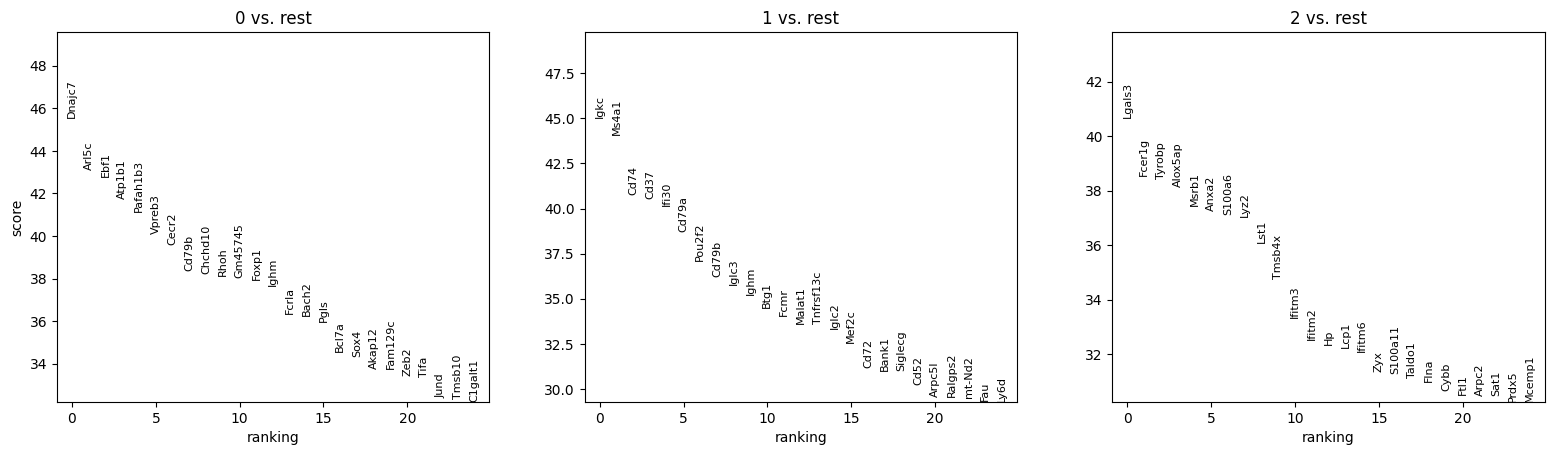

In [14]:
threeclusters = sc.tl.rank_genes_groups(combined_b, "leiden", method="wilcoxon", groups = ["0","1","2"]) # Find marker genes for three largest groups
sc.pl.rank_genes_groups(combined_b, n_genes=25, sharey=False)                                            # Visulalize the top 25 markers                                          

In [15]:
# Generate a DE table 

res = combined_b.uns["rank_genes_groups"]                   # Extrac the result
groups = res["names"].dtype.names                           # Make a list of cluster's name 
pd.DataFrame(                                               # Construct a data frame with statictics data 
    {
        f"Cluster{group}_{key}": res[key][group]
        for group in groups
        for key in ["names", "pvals_adj","logfoldchanges"]
    })


,Cluster0_names,Cluster0_pvals_adj,Cluster0_logfoldchanges,Cluster1_names,Cluster1_pvals_adj,Cluster1_logfoldchanges,Cluster2_names,Cluster2_pvals_adj,Cluster2_logfoldchanges
0,Dnajc7,0.000000e+00,5.047044,Igkc,0.000000e+00,6.590083,Lgals3,0.000000e+00,7.027741
1,Arl5c,0.000000e+00,5.114020,Ms4a1,0.000000e+00,8.438708,Fcer1g,0.000000e+00,6.252474
2,Ebf1,0.000000e+00,5.783269,Cd74,0.000000e+00,6.096878,Tyrobp,0.000000e+00,6.029017
3,Atp1b1,0.000000e+00,5.240828,Cd37,0.000000e+00,3.673259,Alox5ap,0.000000e+00,5.876266
4,Pafah1b3,0.000000e+00,4.734824,Ifi30,0.000000e+00,4.986532,Msrb1,3.693366e-303,4.965186
...,...,...,...,...,...,...,...,...,...
13427,Wapl,1.003627e-97,-3.455977,Txn1,4.570181e-86,-2.113396,Xist,6.008404e-71,-1.477366
13428,Lcp1,2.177217e-102,-3.361207,Gpx1,1.794902e-93,-1.804996,Hmgb1,2.119727e-77,-1.587200
13429,Lmo2,8.347022e-107,-4.026499,Atpif1,3.496749e-94,-2.480050,Chchd10,4.989735e-96,-3.350110
13430,Tuba1b,5.484268e-133,-4.512245,Mki67,4.721410e-106,-5.924100,Ptp4a3,1.187443e-98,-2.531945


In [16]:
# reference: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html
marker_genes = {
    "CD14+ Mono": ["Cd14"],
    "CD16+ Mono": ["Tcf7l2", "Lyn"],
    "cDC2": ["Cst3", "Cotl1", "Dmxl2", "Clec10a"],
    "Erythroblast": ["Mki67"],
    "Proerythroblast": ["Cdk6", "Syngr1", "Gypa"],
    "NK": ["Nkg7", "Cd247", "Fcer1g", "Tyrobp", "Klrg1"],
    "ILC": ["Id2", "Plcg2", "Syne1"],
    "Naive CD20+ B": ["Ms4a1", "Ighd", "Fcrl1", "Ighm"],
    "B cells": [
        "Ms4a1", "Itgb1", "Col4a4", "Prdm1", "Irf4",
        "Pax5", "Bcl11a", "Blk", "Ighd", "Ighm"
    ],
    "Plasma cells": ["Mzb1", "Hsp90b1", "Fndc3b", "Prdm1", "Igkc", "Jchain"],
    "Plasmablast": ["Xbp1", "Prdm1", "Pax5"],
    "CD4+ T": ["Cd4", "Il7r", "Trbc2"],
    "CD8+ T": ["Cd8a", "Gzma", "Ccl5", "Gzmb"],
    "T naive": ["Lef1", "Ccr7", "Tcf7"],
    "pDC": ["Gzmb", "Il3ra", "Cobll1", "Tcf4"],
}

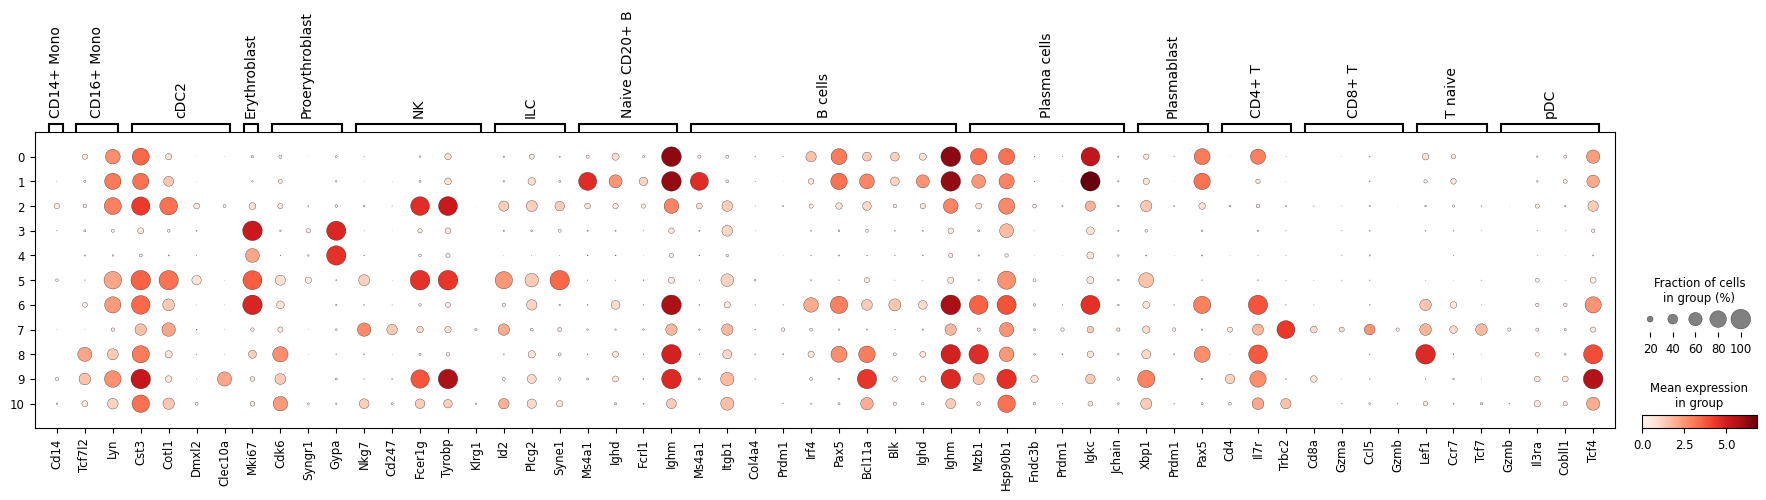

In [17]:
sc.pl.dotplot(combined_b, marker_genes, groupby="leiden", use_raw=True) # To compare the expression of marker genes 

In [18]:
# Annotate cell type for three largest clusters 

combined_b.obs["celltype"] = "None"               
markers = ["B cell", "B cell", "NK cell"]
for i in  range(len(markers)): 
    loc = combined_b.obs["leiden"] == str(i) 
    combined_b.obs.loc[loc,"celltype"] = markers[i]   

combined_b.obs

,Group,Sample,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,n_genes,leiden,celltype
CTCACTGCAGCTACTA_6,Wildtype,Wildtype1,1528,3547.0,29.320553,41.161545,52.495066,71.017761,83.0,2.340006,1528,0,B cell
TGTGCGGTCCTGCTAC_6,Wildtype,Wildtype1,1388,3655.0,36.306430,49.603283,60.683995,75.704514,93.0,2.544460,1388,1,B cell
ACTTAGGTCAGACATC_6,Wildtype,Wildtype1,1903,4724.0,27.603726,38.780694,50.275191,66.574936,108.0,2.286198,1903,0,B cell
ACCTGAACAAATCGGG_6,Wildtype,Wildtype1,2030,16599.0,72.727273,76.245557,80.577143,87.511296,82.0,0.494006,2030,3,None
AAGATAGAGCCTCGTG_6,Wildtype,Wildtype1,3702,15527.0,28.389257,40.368391,51.201134,64.487667,239.0,1.539254,3702,6,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCTCTCACCGTCGA_5,Infected,Infected2,2008,6150.0,33.365854,45.967480,56.829268,71.089431,46.0,0.747967,2008,1,B cell
TTCCTTCTCTTCTGTA_5,Infected,Infected2,3511,12516.0,25.567274,36.497283,46.772132,61.001918,74.0,0.591243,3509,7,None
TTGGATGAGTCGTCTA_5,Infected,Infected2,667,1321.0,38.152914,49.583649,64.647994,87.358062,59.0,4.466313,667,1,B cell
TTGTTCAGTACCACGC_5,Infected,Infected2,2396,7903.0,32.772365,46.476022,56.408959,70.036695,62.0,0.784512,2396,1,B cell


/home1/bioinfo-35/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


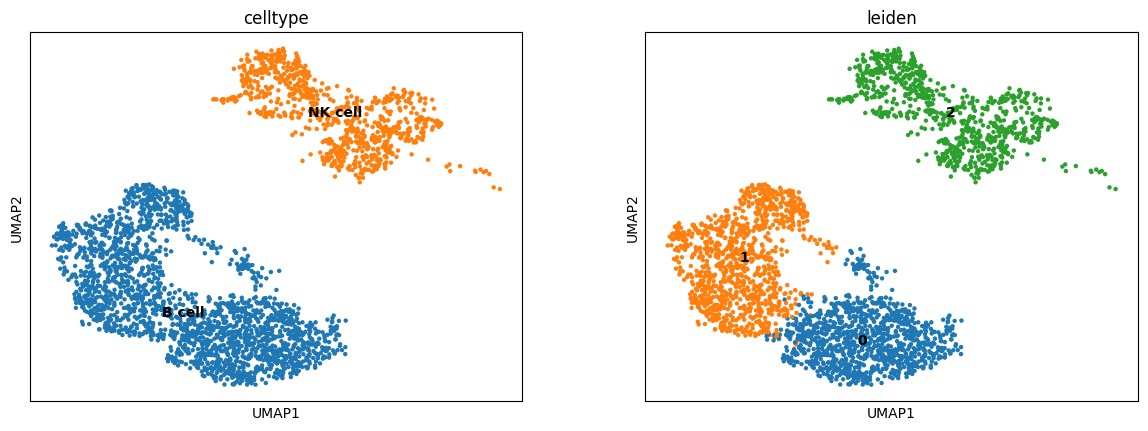

In [19]:
largest = combined_b[combined_b.obs["leiden"].isin(["0","1","2"])] # Make subset  for hte largest three clusters 
sc.pl.umap(largest, color=["celltype", "leiden"], groups = ["B cell","NK cell","0","1","2"], legend_loc = "on data")

## Compare frequency between groups

Text(0, 0.5, 'Frequency of cells')

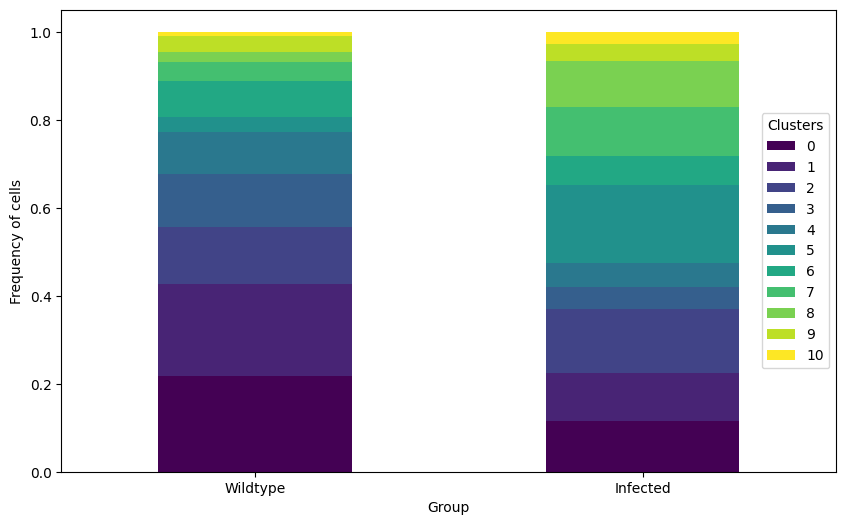

In [20]:
# Create a table for cell frequency per cluster and visualize as the stacked bar plot
freq_table = pd.crosstab(combined_b.obs["Group"], combined_b.obs["leiden"], normalize="index")
freq_table = freq_table.reindex(["Wildtype","Infected"])

# Visualization -> reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html#pandas.DataFrame.plot.bar
bar_plt = freq_table.plot.bar(stacked=True, colormap="viridis", figsize = (10,6))
plt.legend(title="Clusters", loc = "right")
plt.xticks(rotation=0) 
plt.ylabel("Frequency of cells")

## Differential Expression -> Focusing on "Ms4a1" gene

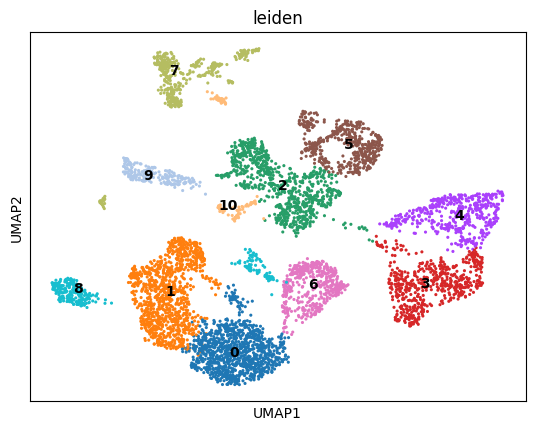

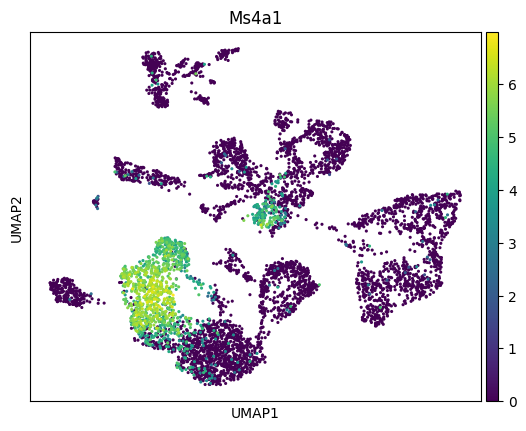

In [21]:
# Find the clusters that shows highly expressed Ms4a1 gene
sc.tl.umap(combined_b)                                             # Run UMAP
sc.pl.umap(combined_b, color = "leiden", legend_loc = "on data")   # To compare cluster's location 
sc.pl.umap(combined_b, color = "Ms4a1")                            # To find the clusters that express Ms4a1

In [22]:
# DE ananlysis with cluster 1 that express Ms4a1 gene highly 
cluster1 = combined_b[combined_b.obs["leiden"]== "1", :].copy()                                                   # Make a subset for cluster 1
sc.tl.rank_genes_groups(cluster1, groupby="Group", groups=["Infected"], reference = "Wildtype",  use_raw = True)  # Run DE in Cluster 1 subset 

res = cluster1.uns["rank_genes_groups"]  # Extract result 

# Create dataframe of result for only infected cells within cluster 1 

c1_infected = pd.DataFrame(
    {
        "Gene": res["names"]["Infected"],
        "adj_p": res["pvals_adj"]["Infected"],
        "logFC": res["logfoldchanges"]["Infected"]
    })

In [23]:
# Fiilter up-regulated genes
Upc1_infected = c1_infected[
    (c1_infected["adj_p"] < 0.01) &
    (c1_infected["logFC"] > 0.5)]

# print out the number of filtered up-regulated genes
print(f" The number of up-regulated genes in the malaria infected cells of Cluster 1 is BBKNN: {len(Upc1_infected)}")
b_Upnumber = len(Upc1_infected)

 The number of up-regulated genes in the malaria infected cells of Cluster 1 is BBKNN: 636


## Pseudo bulk DE based on BBKNN result

In [24]:
# Code refernce for pseudo bulk
# https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html
# https://github.com/mousepixels/sanbomics_scripts/blob/main/pseudobulk_pyDeseq2.ipynb

In [25]:
# Restore the raw data
pseudo_b = combined_raw.copy() 

# Create a new layer and insert the raw expression matrix
pseudo_b.layers["counts"] = pseudo_b.X.copy()
# Match the data with cluster 1 of bbknn reslut. 
pseudo_b = pseudo_b[combined_b.obs["leiden"]== "1", cluster1.var_names].copy() 

# combined_b.obs["leiden"]== "1", cluster1.var_names


In [26]:
#Perform "Pseudo-bulk" 
bulk_b = sc.get.aggregate(
    pseudo_b,
    by=["Sample","Group"],
    layer="counts",
    func="sum")

#Retrieve the result from the "sum" layer  
bulk_b_matrix = bulk_b.layers["sum"]

# Convert count matrix to data frame 
bulk_b.X = bulk_b_matrix
counts = pd.DataFrame(bulk_b.X, columns = bulk_b.var_names, index = bulk_b.obs_names)

In [27]:
# Perform DE analysis
dds_b = DeseqDataSet(
    counts = counts,
    metadata = bulk_b.obs,
    design = "~Group"
)

# Run DESeq2
dds_b.deseq2()

# Perfrom statistical analysis to compare between two groups
stat_b = DeseqStats(dds_b,  contrast=["Group", "Infected", "Wildtype"])
stat_b.summary()

# Make the result to dataframe
res_b = stat_b.results_df 

# Filter the result to extract up-regulated genes
up_b = res_b[
    (res_b["padj"] < 0.01) &
    (res_b["log2FoldChange"] > 0.5)
]

up_b

# Print up-regulated genes in cluster 1 
print(f" The number of up-regulated genes in the malaria infected cells is BBKNN + Pseudo Bulk: {up_b.shape[0]}")

bulk_b_Upnumber = up_b.shape[0]

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.26 seconds.

Fitting dispersion trend curve...
/home1/bioinfo-35/.local/lib/python3.10/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.15 seconds.

/home1/bioinfo-35/.local/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 2.91 seconds.

Fitting LFCs...
... done in 2.02 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: Group Infected vs Wildtype
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
4732440D04Rik  38.836238        0.141055  1.754755  0.080385  0.935931   
Gm37108         0.951563       -0.373080  2.471871 -0.150930  0.880031   
Pcmtd1         82.465228        0.305529  1.742236  0.175366  0.860792   
Gm37409         2.235901       -0.823744  2.107320 -0.390897  0.695874   
Gm38223         2.805893       -0.250023  2.022047 -0.123649  0.901594   
...                  ...             ...       ...       ...       ...   
Vpreb2          0.858536       -2.976938  3.117479 -0.954918  0.339619   
AC140186.1      0.000000             NaN       NaN       NaN       NaN   
Gm15657         0.616588        4.091494  4.147964  0.986386  0.323944   
Erg             0.000000             NaN       NaN       NaN       NaN   
Gfra1           6.188874       -1.685882  1.925009 -0.875779  0.381150   

                   padj  
4732440D04Rik  0.999

... done in 1.09 seconds.



# Integration with Harmony

In [28]:
combined_h = combined.copy()  # To avoid to overlap the result with BBKNN integration                         
sc.external.pp.harmony_integrate(combined_h, key = "Group")

2025-03-31 04:48:04,575 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-31 04:50:34,778 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-31 04:50:35,289 - harmonypy - INFO - Iteration 1 of 10
2025-03-31 04:50:45,339 - harmonypy - INFO - Iteration 2 of 10
2025-03-31 04:50:54,111 - harmonypy - INFO - Iteration 3 of 10
2025-03-31 04:51:03,934 - harmonypy - INFO - Iteration 4 of 10
2025-03-31 04:51:12,504 - harmonypy - INFO - Iteration 5 of 10
2025-03-31 04:51:21,398 - harmonypy - INFO - Iteration 6 of 10
2025-03-31 04:51:26,686 - harmonypy - INFO - Iteration 7 of 10
2025-03-31 04:51:29,608 - harmonypy - INFO - Iteration 8 of 10
2025-03-31 04:51:32,911 - harmonypy - INFO - Iteration 9 of 10
2025-03-31 04:51:35,610 - harmonypy - INFO - Iteration 10 of 10
2025-03-31 04:51:38,612 - harmonypy - INFO - Stopped before convergence


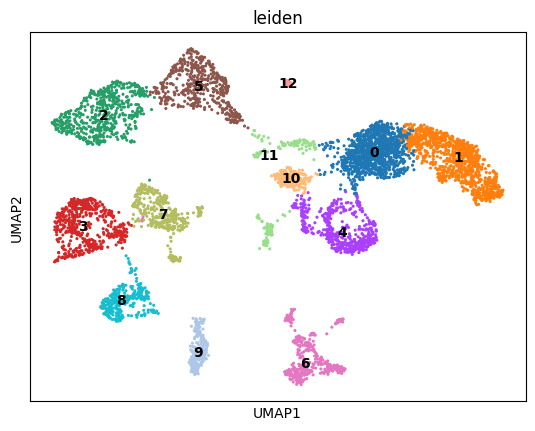

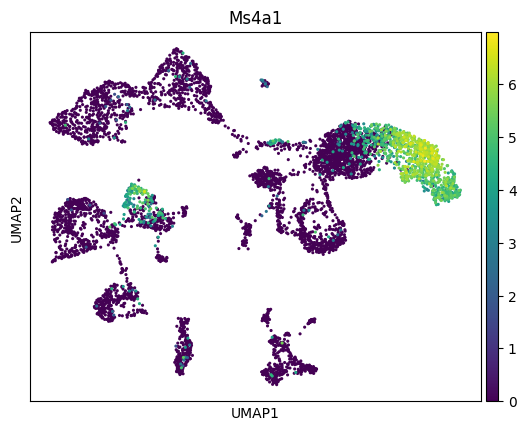

In [29]:
# Find the clusters that shows highly expressed Ms4a1 gene
combined_h.obsm['X_pca'] = combined_h.obsm['X_pca_harmony']               # reference: https://support.parsebiosciences.com/hc/en-us/articles/7704577188500-How-to-analyze-a-1-million-cell-data-set-using-Scanpy-and-Harmony
sc.pp.neighbors(combined_h, n_neighbors = 15)  
sc.tl.leiden(combined_h, resolution = 0.2)                                # Cluster with Leiden graph method

sc.tl.umap(combined_h)                                                    
sc.pl.umap(combined_h, color = "leiden", legend_loc = "on data")          # To compare cluster's location 
sc.pl.umap(combined_h, color = "Ms4a1")                                   # To find the clusters that express Ms4a1

## DE analysis

In [30]:
# DE ananlysis with cluster 1 that express Ms4a1 gene highly 
cluster1_h = combined_h[combined_h.obs["leiden"]== "1", :].copy()  # Make a subset for cluster 1
sc.tl.rank_genes_groups(cluster1_h, groupby="Group", groups=["Infected"], reference = "Wildtype",  use_raw = True)  # Run DE in Cluster 1 subset 

res = cluster1_h.uns["rank_genes_groups"]  # Extract result 

# Create dataframe of result for only infected cells within cluster 1 
c1_infected = pd.DataFrame(
    {
        "Gene": res["names"]["Infected"],
        "adj_p": res["pvals_adj"]["Infected"],
        "logFC": res["logfoldchanges"]["Infected"]
    })

In [31]:
# Fiilter up-regulated genes
Upc1_infected = c1_infected[
    (c1_infected["adj_p"] < 0.01) &
    (c1_infected["logFC"] > 0.5)]

# print out the number of filtered up-regulated genes
print(f" The number of up-regulated genes in the malaria infected cells of Cluster 1 is Harmony: {len(Upc1_infected)}")
h_Upnumber = len(Upc1_infected)

 The number of up-regulated genes in the malaria infected cells of Cluster 1 is Harmony: 610


## Pseudo bulk DE based on Harmony result

In [32]:
# Restore the raw data
pseudo_h = combined_raw.copy() 

# Create a new layer and insert the raw expression matrix
pseudo_h.layers["counts"] = pseudo_h.X.copy()

# Match the data with cluster 1 of harmony reslut. 
pseudo_h = pseudo_h[combined_h.obs["leiden"]== "1", cluster1_h.var_names].copy() 


In [33]:
#Perform "Pseudo-bulk" 
bulk_h = sc.get.aggregate(
    pseudo_h,
    by=["Sample","Group"],
    layer="counts",
    func="sum")

#Retrieve the result from the "sum" layer  
bulk_h_matrix = bulk_h.layers["sum"]

# Convert count matrix to data frame 
bulk_h.X = bulk_h_matrix
counts = pd.DataFrame(bulk_h.X, columns = bulk_h.var_names, index = bulk_h.obs_names)


In [34]:
# Perform DE analysis
dds_h = DeseqDataSet(
    counts = counts,
    metadata = bulk_h.obs,
    design = "~Group"
)

# Run DESeq2
dds_h.deseq2()

# Perfrom statistical analysis to compare between two groups
stat_h = DeseqStats(dds_h,  contrast=["Group", "Infected", "Wildtype"])
stat_h.summary()

# Make the result to dataframe
res_h = stat_h.results_df 

# Filter the result to extract up-regulated genes
up_h = res_h[
    (res_h["padj"] < 0.01) &
    (res_h["log2FoldChange"] > 0.5)]

up_h

# Print up-regulated genes in cluster 1 
print(f" The number of up-regulated genes in the malaria infected cells is Harmony + Pseudo Bulk: {up_h.shape[0]}")

bulk_h_Upnumber = up_h.shape[0]

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.50 seconds.

Fitting dispersion trend curve...
/home1/bioinfo-35/.local/lib/python3.10/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.14 seconds.

/home1/bioinfo-35/.local/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 2.85 seconds.

Fitting LFCs...
... done in 2.51 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: Group Infected vs Wildtype
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
4732440D04Rik  37.208219        0.125938  1.758223  0.071628  0.942898   
Gm37108         1.499779        0.508744  2.281786  0.222959  0.823568   
Pcmtd1         77.938819        0.301973  1.744390  0.173111  0.862564   
Gm37409         2.346291       -1.040132  2.105169 -0.494085  0.621246   
Gm38223         2.699903       -0.205447  2.028299 -0.101290  0.919320   
...                  ...             ...       ...       ...       ...   
Vpreb2          0.297208       -1.482845  3.192608 -0.464462  0.642317   
AC140186.1      0.000000             NaN       NaN       NaN       NaN   
Gm15657         0.605707        4.003098  4.148920  0.964853  0.334618   
Erg             0.000000             NaN       NaN       NaN       NaN   
Gfra1           5.298289       -0.707928  1.909726 -0.370696  0.710864   

                   padj  
4732440D04Rik  0.999

... done in 1.29 seconds.



## Result bar plot 

Text(0, 0.5, 'the number of genes')

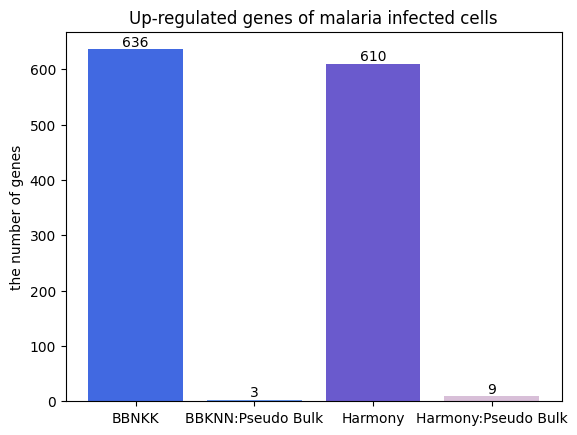

In [35]:
# Summurize the integration and pesudo bulk analysis results 

# Create the dictionay to gather the result 
up_numbers = {"BBNKK": b_Upnumber,
              "BBKNN:Pseudo Bulk" : bulk_b_Upnumber,
              "Harmony": h_Upnumber,
              "Harmony:Pseudo Bulk": bulk_h_Upnumber }

# each bar colors 
colors = ['royalblue', 'cornflowerblue', 'slateblue', 'thistle']

# Create bar color 
plt.bar(range(len(up_numbers)), list(up_numbers.values()), tick_label = list(up_numbers.keys()), color = colors)

# Assignn each value on bar
for i, val in enumerate(list(up_numbers.values())):
    plt.text(i, val + 0.1, int(val), ha='center', va='bottom')
    
plt.title('Up-regulated genes of malaria infected cells')
plt.ylabel('the number of genes')


# Trajectory analysis

## PAGA

In [36]:
# Preprocessing and clustering 
paga = combined.copy()                           # To avoid to overlap the result
sc.tl.pca(paga, svd_solver="arpack")             # Run PCA 
sc.pp.neighbors(paga, n_neighbors=15, n_pcs=32)  # Compute neighbors 
sc.tl.leiden(paga, resolution = 0.2)             # clustering 

In [37]:
# Denoising the graph
sc.tl.diffmap(paga)                                         # compute a diffusion map                                  
sc.pp.neighbors(paga, n_neighbors=15, use_rep="X_diffmap")

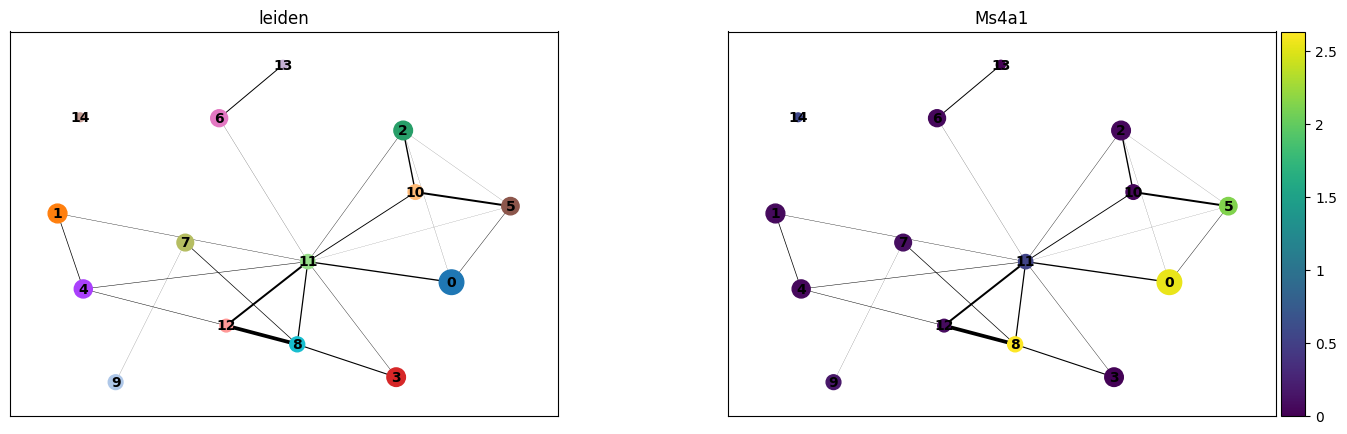

In [38]:
# Run PAGA
sc.tl.paga(paga, groups="leiden")           # Run Paga
sc.pl.paga(paga, color=["leiden", "Ms4a1"]) # Focus on Ms4a1 marker gene 

## Embedding on UMAP 

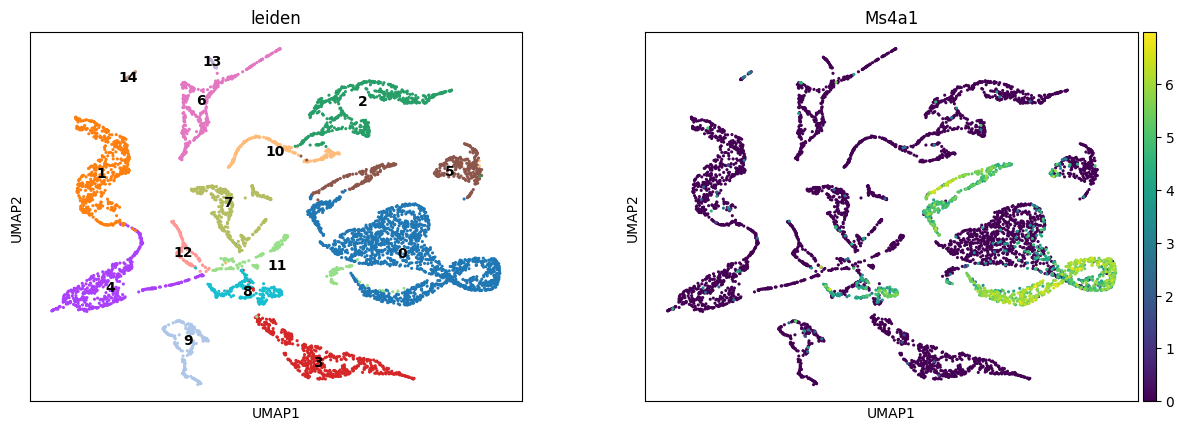

In [39]:
# Run and visualize UMAP
sc.tl.umap(paga, init_pos = "paga")                                    # Run UMAP
sc.pl.umap(paga, color = ["leiden", "Ms4a1"], legend_loc = "on data")  # Visualize the UMAP result

## Embedding on PHATE

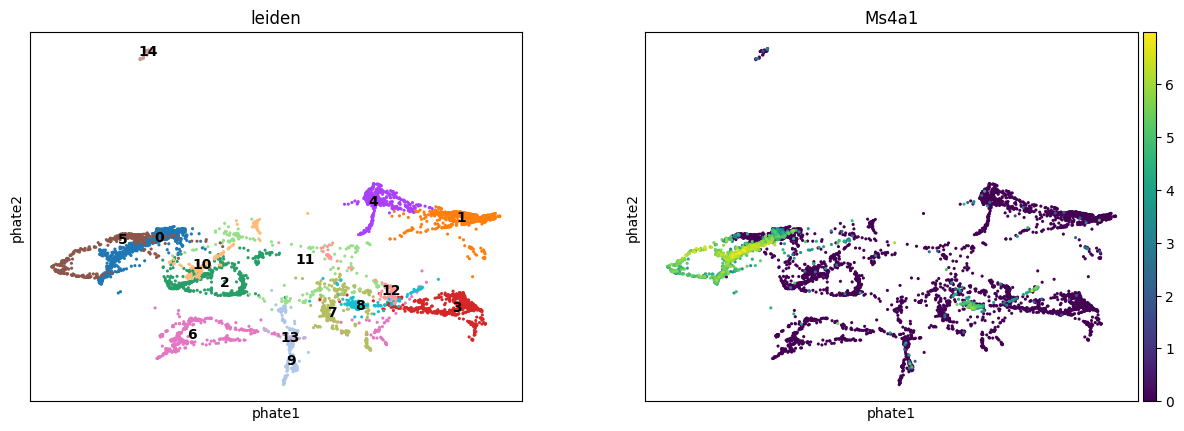

In [40]:
sc.external.tl.phate(paga, n_pca = 32)                                          # Run Phate
sc.external.pl.phate(paga, color = ["leiden", "Ms4a1"], legend_loc = "on data") # Visulalize Phate result 